In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [153]:
class Pair:
    def __init__(self, asset1, asset2, conversion=None):
        self.asset1 = asset1
        self.asset2 = asset2
        self.conversion = conversion

    def backtest(self, start_date, end_date, window, entry_threshold, exit_threshold, reverse=False, visualize=False, realistic=True):
        df = yf.download([self.asset1, self.asset2], start=start_date, end=end_date, auto_adjust=True, progress=False)["Close"]

        if (self.conversion is not None):
            rate = yf.download(self.conversion, start=start_date, end=end_date, auto_adjust=True, progress=False)["Close"]
            df [self.asset1] *= rate[self.conversion]
            df.dropna(inplace=True)
            
        df["ratio"] = df[self.asset1] / df[self.asset2]

        print("p-value from ADF test: ", adfuller(df["ratio"])[1])

        if (reverse):
            df.loc[:, :] = df.iloc[::-1].values

        df["ratio_ma"] = df["ratio"].rolling(window=window).mean()
        df["ratio_std"] = df["ratio"].rolling(window=window).std()
        df["z_score"] = (df["ratio"] - df["ratio_ma"]) / df["ratio_std"]
        df[f"{self.asset1} return"] = df[self.asset1].pct_change()
        df[f"{self.asset2} return"] = df[self.asset2].pct_change()
        df.dropna(inplace=True)

        positions = pd.DataFrame(0.0, index=df.index, columns=[self.asset1, self.asset2])

        # Trading logic 
        open_position = False
        for i in range(len(df)):
            if open_position == False:
                if df["z_score"].iloc[i] > entry_threshold:
                    positions.iloc[i] = [-0.5, 0.5]  # Short asset1 with 50% of fund, Long asset2 with 50% of fund
                    open_position = True
                elif df["z_score"].iloc[i] < -entry_threshold:
                    positions.iloc[i] = [0.5, -0.5]  # Long asset1, Short asset2
                    open_position = True
            else:
                if abs(df["z_score"].iloc[i]) < exit_threshold:
                    positions.iloc[i] = [0, 0]
                    open_position = False
                else:
                    positions.iloc[i] = positions.iloc[i-1]

        # Shift positions by 1 day for backtesting
        positions_copy = positions.copy()
        positions_copy = positions_copy.shift(1)
        positions_copy.fillna(0, inplace=True)

        returns = pd.DataFrame(index=df.index)
        returns[self.asset1] = positions_copy[self.asset1] * df[f"{self.asset1} return"]
        returns[self.asset2] = positions_copy[self.asset2] * df[f"{self.asset2} return"]
        returns["total"] = (returns[self.asset1] + returns[self.asset2])

        if (realistic):
            # Apply platform fee (0.1%) and bid-ask spread (0.025%)
            position_changes = (positions_copy != positions_copy.shift(1))
            position_changes.iloc[0] = False
            
            for column in [self.asset1, self.asset2]:
                trading_costs = position_changes[column].astype(int) * (-0.00125)
                returns[column] = returns[column] + trading_costs

            returns['total'] = returns.drop('total', axis=1).sum(axis=1)

        portfolio_value = (1 + returns["total"]).cumprod()

        if (visualize):
            fig, (ax1, ax4, ax2, ax3) = plt.subplots(4, 1, figsize=(12, 12))
            
            # Plot 1: Price ratio over time
            ax1.plot(df["z_score"])
            ax1.axhline(y=entry_threshold, color="r", linestyle="--")
            ax1.axhline(y=-entry_threshold, color="r", linestyle="--")
            ax1.axhline(y=exit_threshold, color="y", linestyle="--")
            ax1.axhline(y=-exit_threshold, color="y", linestyle="--")
            ax1.axhline(y=0, color="black", linestyle="-")
            open_signals = positions[(positions[self.asset1] != 0) & (positions.shift(1)[self.asset1] == 0)].index
            close_signals = positions[(positions[self.asset1] == 0) & (positions.shift(1)[self.asset1] != 0)].index[1:]
            ax1.scatter(open_signals, df.loc[open_signals, "z_score"], 
                       marker="o", color="black", s=100, label="Position Opened", facecolor="none", edgecolor="black")
            ax1.scatter(close_signals, df.loc[close_signals, "z_score"], 
                       marker="o", color="black", s=100, label="Position Closed")
            ax1.set_title("Z-Score of Ratio")
            ax1.set_xticks(df.index)
            ax1.grid(True)
            
            # Plot 2 and 3: Stock prices with buy/sell indicators
            ax2.plot(df.index, df[self.asset1], label=self.asset1, color="blue")
            long_signals = positions[(positions[self.asset1] > 0) & (positions.shift(1)[self.asset1] == 0)].index
            short_signals = positions[(positions[self.asset1] < 0) & (positions.shift(1)[self.asset1] == 0)].index
            ax2.scatter(long_signals, df.loc[long_signals, self.asset1], 
                       marker="^", color="green", s=100, label="Long Signal")
            ax2.scatter(short_signals, df.loc[short_signals, self.asset1], 
                       marker="v", color="red", s=100, label="Short Signal")
            ax2.scatter(close_signals, df.loc[close_signals, self.asset1], 
                       marker="o", color="black", s=100, label="Position Closed")
            ax2.set_title(f"{self.asset1} Prices with Trading Signals")
            ax2.grid(True)
            ax2.legend()
            
            ax3.plot(df.index, df[self.asset2], label=self.asset2, color="blue")
            long_signals = positions[(positions[self.asset2] > 0) & (positions.shift(1)[self.asset2] == 0)].index
            short_signals = positions[(positions[self.asset2] < 0) & (positions.shift(1)[self.asset2] == 0)].index
            ax3.scatter(long_signals, df.loc[long_signals, self.asset2], 
                       marker="^", color="green", s=100, label="Long Signal")
            ax3.scatter(short_signals, df.loc[short_signals, self.asset2], 
                       marker="v", color="red", s=100, label="Short Signal")
            ax3.scatter(close_signals, df.loc[close_signals, self.asset2], 
                       marker="o", color="black", s=100, label="Position Closed")
            ax3.set_title(f"{self.asset2} Prices with Trading Signals")
            ax3.grid(True)
            ax3.legend()
            
            # Plot 4: Portfolio returns over time
            ax4.plot(df.index, portfolio_value, label="Portfolio Value", color="purple")
            ax4.set_title("Portfolio Value Over Time")
            ax4.grid(True)
            ax4.legend()

            plt.tight_layout()
            plt.show()

        return positions, returns

In [154]:
class PerformanceMetrics:
    def __init__(self, positions, returns):
        self.positions = positions.copy()
        self.returns = returns.copy()
        self.portfolio_value = self._calculate_portfolio_value()
        
    def _calculate_portfolio_value(self):
        return (1 + self.returns['total']).cumprod()
    
    def _calculate_sharpe_ratio(self, risk_free_rate=0.043, periods_per_year=252):
        if isinstance(self.returns, pd.DataFrame) and 'total' in self.returns.columns:
            returns_series = self.returns['total']
        else:
            returns_series = self.returns
            
        excess_returns = returns_series - (risk_free_rate / periods_per_year)
        return np.sqrt(periods_per_year) * (excess_returns.mean() / returns_series.std())
    
    def _calculate_max_drawdown(self):
        return (self.portfolio_value / self.portfolio_value.cummax() - 1).min()
    
    def _calculate_trade_statistics(self):  
        trade_changes = (self.positions != self.positions.shift(1)).any(axis=1)
        num_trades = (trade_changes.sum() - 1) / 2
        avg_holding_period = len(self.positions) / num_trades if num_trades > 0 else 0
        days_with_positions = (self.positions != 0).any(axis=1).sum()
        days_without_positions = (self.positions == 0).all(axis=1).sum()
        
        return {
            'number_of_trades': num_trades,
            'avg_holding_period': avg_holding_period,
            'days_with_positions': days_with_positions,
            'days_without_positions': days_without_positions
        }
    
    def generate_report(self, risk_free_rate=0.043):
        return {
            'final_portfolio_value': self.portfolio_value.iloc[-1],
            'sharpe_ratio': self._calculate_sharpe_ratio(risk_free_rate),
            'max_drawdown': self._calculate_max_drawdown(),
            'total_return': (self.portfolio_value.iloc[-1] - 1) * 100,
            'annualized_return': (self.portfolio_value.iloc[-1] ** (252/len(self.portfolio_value)) - 1) * 100,
            'trade_statistics': self._calculate_trade_statistics()
        }

In [155]:
# IBIT, ARKB, BITB, GBTC, FBTC, BTC
pair1 = Pair(asset1="BTC-EUR", asset2="BTC-USD", conversion="EURUSD=X")

p-value from ADF test:  7.060346170994718e-30


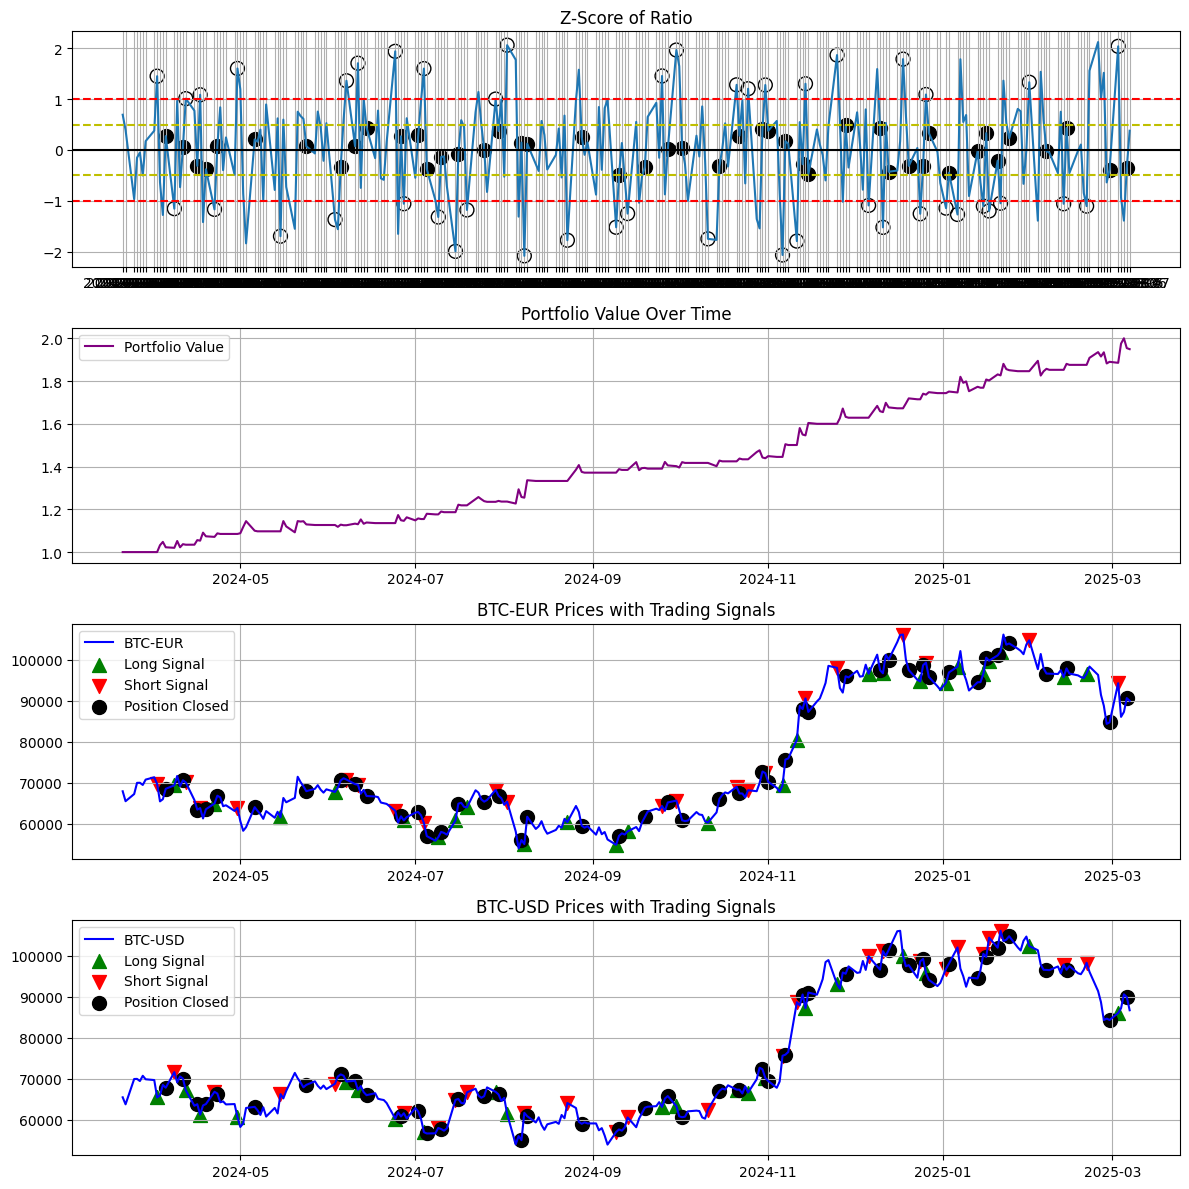

In [156]:
positions, returns = pair1.backtest(start_date="2024-03-08", 
                                    end_date="2025-03-08", 
                                    window=10, 
                                    entry_threshold=1, 
                                    exit_threshold=0.5, 
                                    visualize=True);

In [157]:
pm = PerformanceMetrics(positions=positions, returns=returns)

metrics = pm.generate_report()

print("Performance Report")
print("=================")
print(f"Final Portfolio Value: {metrics['final_portfolio_value']:.4f}")
print(f"Total Return: {metrics['total_return']:.2f}%")
print(f"Annualized Return (CAGR): {metrics['annualized_return']:.2f}%")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Maximum Drawdown: {metrics['max_drawdown']:.2%}")

if metrics['trade_statistics']:
    print("\nTrading Statistics")
    print("-----------------")
    print(f"Number of trades: {metrics['trade_statistics']['number_of_trades']}")
    print(f"Average holding period: {metrics['trade_statistics']['avg_holding_period']:.1f} days")
    print(f"Days with positions: {metrics['trade_statistics']['days_with_positions']}")
    print(f"Days without positions: {metrics['trade_statistics']['days_without_positions']}")

Performance Report
Final Portfolio Value: 1.9490
Total Return: 94.90%
Annualized Return (CAGR): 95.42%
Sharpe Ratio: 2.79
Maximum Drawdown: -4.59%

Trading Statistics
-----------------
Number of trades: 46.0
Average holding period: 5.5 days
Days with positions: 104
Days without positions: 147


Notes:

Reverse dataset to test on bearish market

Implement adaptive parameters - have another larger rolling window to change parameters on the fly

In [111]:
grid_results = pd.DataFrame(columns=["window", "entry_threshold", "exit_threshold", "total_return", "sharpe_ratio", "max_drawdown"])

for window in [5, 7, 10, 15]:
    for entry_threshold in [0.5, 1, 1.2]:
        for exit_threshold in [0.3, 0.5, 1]:
            positions, returns = pair1.backtest(
                start_date="2024-3-08", 
                end_date="2025-03-08", 
                window=window, 
                entry_threshold=entry_threshold, 
                exit_threshold=exit_threshold
            )
            pm = PerformanceMetrics(positions=positions, returns=returns)
            report = pm.generate_report()
            grid_results.loc[len(grid_results)] = [window, entry_threshold, exit_threshold, report['total_return'], report['sharpe_ratio'], report['max_drawdown']]

print(grid_results["total_return"].mean(), grid_results["sharpe_ratio"].mean(), grid_results["max_drawdown"].mean())
grid_results

68.27055467035203 1.9125818841665607 -0.0899023621668133


,window,entry_threshold,exit_threshold,total_return,sharpe_ratio,max_drawdown
0,5.0,0.5,0.3,15.863973,0.476156,-0.076371
1,5.0,0.5,0.5,39.312006,1.079863,-0.074004
2,5.0,0.5,1.0,59.940273,1.576046,-0.093091
3,5.0,1.0,0.3,32.336084,0.907105,-0.069687
4,5.0,1.0,0.5,52.275269,1.463939,-0.085049
5,5.0,1.0,1.0,69.815364,1.953480,-0.085049
6,5.0,1.2,0.3,40.731964,1.166790,-0.069687
7,5.0,1.2,0.5,47.081786,1.437476,-0.085049
8,5.0,1.2,1.0,56.783680,1.791362,-0.085049
9,7.0,0.5,0.3,40.593792,1.095476,-0.093091
